In [ ]:
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

In [ ]:
#%pip install SimpleITK
#import SimpleITK as sitk
from scipy import ndimage
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ff = glob.glob('/content/drive/My Drive/niftii/*')

In [ ]:
ff[0]

'/content/drive/My Drive/niftii/1_.nii.gz'

In [ ]:
len(ff)

30

In [ ]:
images = []

In [ ]:
desired_depth = 162
desired_width = 200
desired_height = 200

In [ ]:
for f in range(len(ff)):
    a = nib.load(ff[f])
    a = a.get_data()
        
   
    current_depth = a.shape[2]
    current_width = a.shape[0]
    current_height = a.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
   
    
    a = ndimage.zoom(a, (width_factor, height_factor, depth_factor), order=1)  

    print (a.shape)
    for i in range(a.shape[2]):
        images.append((a[:,:,i]))
print (a.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)
(200, 200, 162)


In [ ]:
print(width_factor, height_factor)
print(len(images))
print(images[0].shape)



0.5 0.5
4860
(200, 200)


In [ ]:
#images = np.asanyarray(images,dtype='int64')
images = np.asanyarray(images)


In [ ]:
images.shape

(4860, 200, 200)

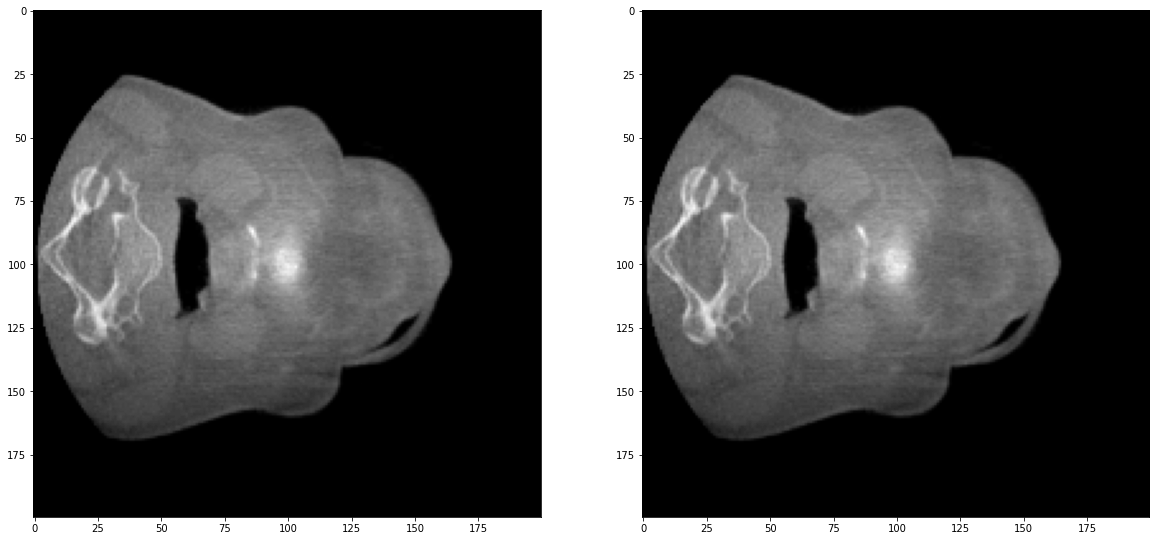

In [ ]:
plt.figure(figsize=[20,20])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(images[0], (200,200))
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
plt.imshow(curr_img, cmap='gray')


You'll first convert each 173 x 173 image into a matrix of size 173 x 173 x 1, which you can feed into the network

Next, rescale the data with using max-min normalisation:

In [ ]:
m = np.max(images)
mi = np.min(images)
mi = np.float64(mi)
m = np.float64(m)

In [ ]:
m, mi

(26619.0, -7402.0)

In [ ]:
images = (images - mi) / (m - mi)

In [ ]:
np.min(images), np.max(images)

(0.0, 1.0)

In [ ]:
images.shape
print(images.shape)

(4860, 200, 200)


In [ ]:
for i in range(4860) :
  np.savetxt('/content/drive/My Drive/all_images/data' + str(i) + '.csv' ,images[i], delimiter=',')

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images,
                                                             test_size=0.2,
                                                             random_state=13)

In [ ]:
from sklearn.model_selection import train_test_split

x, valid_X, y, valid_ground = train_test_split(images,images,test_size=0.2,train_size=0.8, random_state=13)
train_X, x_cv, train_ground, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75, random_state=13)

In [ ]:
print("Dataset (images) shape: {shape}".format(shape=images.shape))

Dataset (images) shape: (9300, 200, 200, 1)


In [ ]:
batch_size = 8
epochs = 20
inChannel = 1
x, y = 200, 200
input_img = Input(shape = (x, y, inChannel))

In [ ]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    #drop1 = Dropout(0.1, noise_shape=None, seed=None)(conv1)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    #conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    #drop1 = Dropout(0.1, noise_shape=None, seed=None)(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    #conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    #conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    #drop2 = Dropout(0.1, noise_shape=None, seed=None)(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    #conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    #conv3 = BatchNormalization()(conv3)


    #decoder
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2) #7 x 7 x 128 (small and thick)
    #conv3 = BatchNormalization()(conv3)
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    #conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    #conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    #conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    #conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    #conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='binary_crossentropy', optimizer = Adam(), metrics=['mae'])

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0     

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/20
243/243 [==============================] - 4628s 19s/step - loss: 0.5122 - mae: 0.0224 - val_loss: 0.5046 - val_mae: 0.0039
Epoch 2/20
 48/243 [====>.........................] - ETA: 3:29 - loss: 0.5048 - mae: 0.0055

In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoderbsize16ep50rms.h5')

In [ ]:
autoencoder = load_model('/content/drive/MyDrive/autoencoderbsize8adam.h5')

In [ ]:
valid_X2=valid_X[:10]

In [ ]:
pred = autoencoder.predict(valid_X2)

In [ ]:
a1 = pred[0]
a2 = valid_ground[0]
cm = np.corrcoef(a1.flat, a2.flat)
r = cm[0, 1]
print(r)

0.9970074421676407


In [ ]:
# - compatibility with Python 2
from __future__ import print_function 
from __future__ import division  

In [ ]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

%matplotlib inline

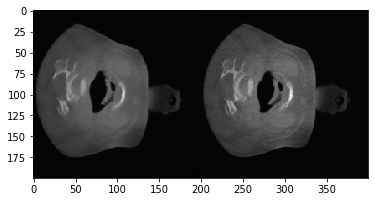

In [ ]:
a1 = a1.reshape(200,200)
a2 = a2.reshape(200,200)
plt.imshow(np.hstack((a1,a2 )))

Text(0.5, 1.0, 'a2 slice histogram')

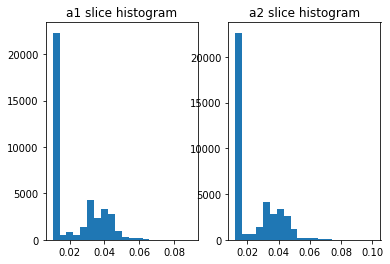

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(a1.ravel(), bins=20)

axes[0].set_title('a1 slice histogram')

axes[1].hist(a2.ravel(), bins=20)

axes[1].set_title('a2 slice histogram')


0.9970074421676407

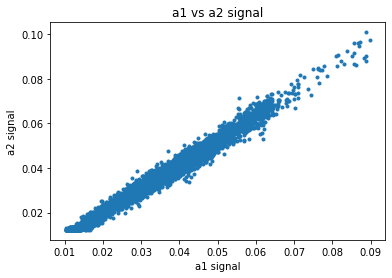

In [ ]:
plt.plot(a1.ravel(), a2.ravel(), '.')
plt.xlabel('a1 signal')

plt.ylabel('a2 signal')

plt.title('a1 vs a2 signal')

np.corrcoef(a1.ravel(), a2.ravel())[0, 1]

Text(0.5, 1.0, 'a2')

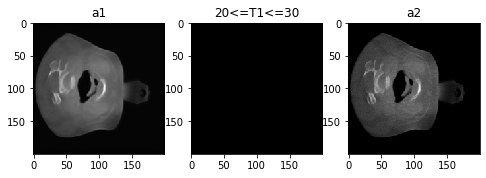

In [ ]:
# Array that is True if T1 signal >= 20, <= 30, False otherwise
t1_20_30 = (a1 >= 20) & (a1 <= 30)
# Show T1 slice, mask for T1 between 20 and 30, T2 slice
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(a1)

axes[0].set_title('a1')

axes[1].imshow(t1_20_30)

axes[1].set_title('20<=T1<=30')

axes[2].imshow(a2)

axes[2].set_title('a2')


Text(0, 0.5, 'a2 signal bin')

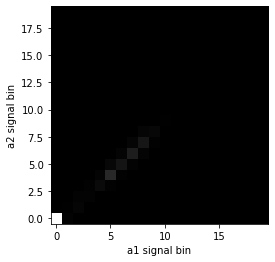

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d(
     a1.ravel(),
     a2.ravel(),
     bins=20)
# Plot as image, arranging axes as for scatterplot
# We transpose to put the T1 bins on the horizontal axis
# and use 'lower' to put 0, 0 at the bottom of the plot
plt.imshow(hist_2d.T, origin='lower')

plt.xlabel('a1 signal bin')

plt.ylabel('a2 signal bin')


Text(0, 0.5, 'a2 signal bin')

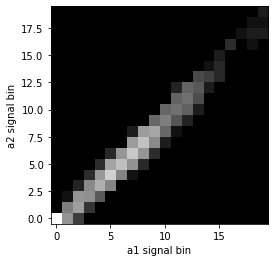

In [ ]:
#Show log histogram, avoiding divide by 0
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

plt.xlabel('a1 signal bin')

plt.ylabel('a2 signal bin')


In [ ]:
def mutual_information(hgram):
     """ Mutual information for joint histogram
     """
     # Convert bins counts to probability values
     pxy = hgram / float(np.sum(hgram))
     px = np.sum(pxy, axis=1) # marginal for x over y
     py = np.sum(pxy, axis=0) # marginal for y over x
     px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
     # Now we can do the calculation using the pxy, px_py 2D arrays
     nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
     return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
mutual_information(hist_2d)

1.263187042160614

Test Images


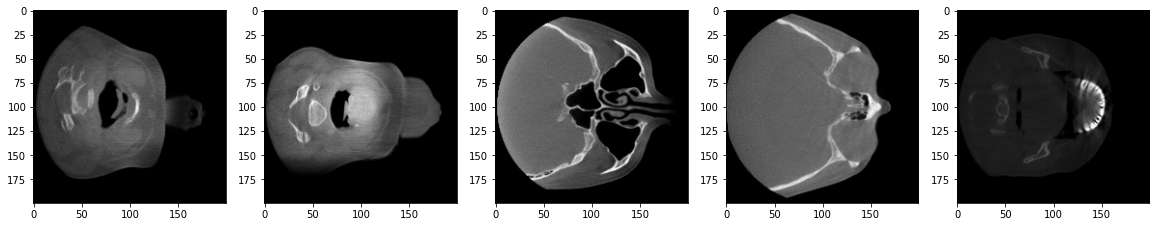

Reconstruction of Test Images


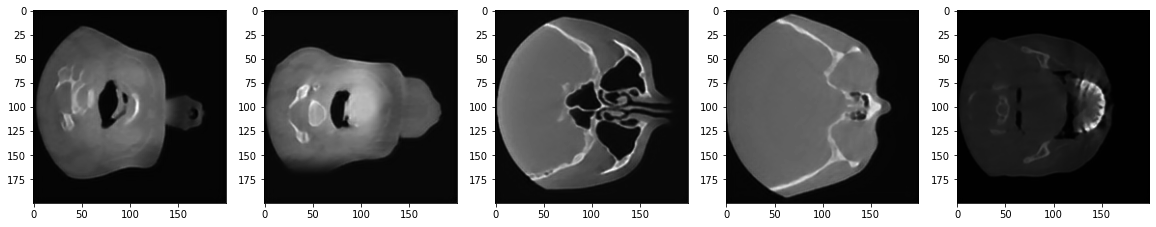

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    #plt.imshow(x_cv[i, ..., 0], cmap='gray')
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
#autoencoder.save_weights('/content/drive/MyDrive/autoencoder_mri.h5')

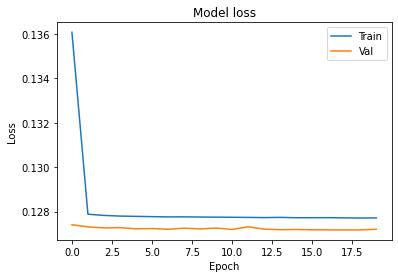

In [ ]:
plt.plot(autoencoder_train.history['loss'])
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

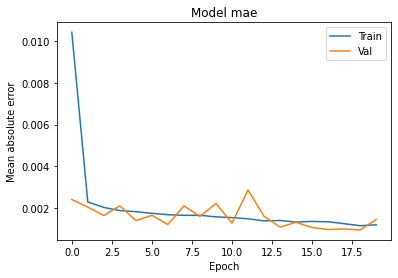

In [ ]:
plt.plot(autoencoder_train.history['mae'])
plt.plot(autoencoder_train.history['val_mae'])
plt.title('Model mae')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
valid_pred = autoencoder.predict(valid_X)
mse =  np.mean((valid_X - valid_pred) ** 2)
psnr = 20 * math.log10( 1.0 / math.sqrt(mse))
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr,2)))

PSNR of reconstructed validation images: 51.7dB


In [ ]:
autoencoder.evaluate(valid_X, valid_ground)

10/10 [==============================] - 1s 94ms/step - loss: 2.7699e-06 - mae: 0.0011


[2.769857928797137e-06, 0.0010929749114438891]

In [ ]:
[a,b,c,d]= np.shape(valid_X)
mean = 0
sigma = 0.03
gauss = np.random.normal(mean,sigma,(a,b,c,d))
noisy_images = valid_X + gauss

In [ ]:
pred_noisy = autoencoder.predict(noisy_images)

In [ ]:
plt.figure(figsize=(20, 4))
print("Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(noisy_images[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred_noisy[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
noisy_pred = autoencoder.predict(noisy_images)
mse =  np.mean((valid_X - noisy_pred) ** 2)
psnr_noisy = 20 * math.log10( 1.0 / math.sqrt(mse))

In [ ]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr_noisy,2)))

In [ ]:
from keras.models import load_model
modell = load_model('/content/drive/MyDrive/autoencoderbsize16ep50rms.h5')



In [ ]:
predd = modell.predict(images)

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(predd[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
valid_pred = modell.predict(valid_X)
mse =  np.mean((valid_X - valid_pred) ** 2)
psnr = 20 * math.log10( 1.0 / math.sqrt(mse))
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr,2)))